In [27]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tqdm import tqdm
import gc

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from collections import defaultdict

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import random

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

import sys
sys.path.append('../../')
from utils import *

import pickle
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import PIL
from tqdm import tqdm

Running on device: CUDA


In [28]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [29]:
with open('./imbalanced_dataset.pkl', 'rb') as file:
    imbalanced_aug_dataset_id = pickle.load(file)

train_idx = np.load('./train_idx.npy')
retain_idx = np.load('./retain_idx.npy')
forget_idx = np.load('./forget_idx.npy')
val_idx = np.load('./val_idx.npy')
test_idx = np.load('./test_idx.npy')

train_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, train_idx)
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)
val_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, val_idx)
test_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, test_idx)

In [30]:
# '''
# Get retain forget indices
# '''
# extracted_data = []
# for i in range(len(train_set)):
#     dp = train_set[i]
#     extracted_data.append(dp)
# grouped_data = defaultdict(list)

# for item in extracted_data:
#     grouped_data[item[2]].append(item)
# unique_item = list(grouped_data.keys())

# random.shuffle(unique_item)

# split_index = int(len(unique_item) * 0.98)
# train_item_ids = set(unique_item[:split_index])
# test_item_ids = set(unique_item[split_index:])
# retain_indices = [i for i, item in enumerate(extracted_data) if item[2] in train_item_ids]
# forget_indices = [i for i, item in enumerate(extracted_data) if item[2] in test_item_ids]
# np.save('./retain_idx.npy', retain_indices)
# np.save('./forget_idx.npy', forget_indices)
# len(retain_indices), len(forget_indices), len(forget_indices)/len(retain_indices)

In [31]:
class CustomDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        x, y, z = self.data_list[idx]

        # If x is a PIL.Image, convert it to a tensor
        if isinstance(x, PIL.Image.Image):
            x = transforms.ToTensor()(x)

        # Apply additional transformations (like normalization)s
        if self.transform:
            x = self.transform(x)

        return (x, y)  # Explicitly return as tuple

# download and pre-process CIFAR10
train_normalize = transforms.Compose(
    [
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

test_normalize = transforms.Compose(
    [
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

forget_dataset = CustomDataset(forget_set, transform=train_normalize)
retain_dataset = CustomDataset(retain_set, transform=test_normalize)
val_dataset = CustomDataset(val_set, transform=test_normalize)

In [32]:
batch_size = 8

retain_loader = DataLoader(retain_dataset, batch_size=batch_size, shuffle=True)#, generator=RNG)
forget_loader = DataLoader(forget_dataset, batch_size=batch_size, shuffle=True)#, generator=RNG)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)#, generator=RNG)

In [33]:
list_of_targets = []

with torch.no_grad():
    for sample in retain_loader:
        # Get logits
        targets = sample[1]
        list_of_targets.append(np.array(targets))
        
retain_class_weights = torch.tensor(1/np.bincount(np.concatenate(list_of_targets).ravel())).to(DEVICE, dtype=torch.float32)

In [34]:
for k in tqdm(range(9)):

    # load model with pre-trained weights
    net = resnet18(weights=None, num_classes=10)
    net.to(DEVICE);

    epochs = 30
    val_loss = np.inf


    current_batch = 0
    total_samples = len(retain_loader.dataset)
    batch_size = retain_loader.batch_size
    batches_per_epoch  = math.ceil(total_samples / batch_size)
    total_batches = epochs * batches_per_epoch
    initial_lr = 1e-4
    warmup_batches = math.ceil(10*total_batches)


    criterion = nn.CrossEntropyLoss(weight=retain_class_weights)
    optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.90, weight_decay=5e-2)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []


    for ep in range(epochs):

        net.train()

        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            current_batch += 1

            # # Warm-up for the first 'warmup_batches' batches
            # if current_batch <= warmup_batches:
            #     adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            # nn.utils.clip_grad_value_(net.parameters(), 10)

            optimizer.step()


        net.eval()  # handle drop-out/batch norm layers

        loss = 0
        with torch.no_grad():
            for x,y in retain_loader:
                out = net(x.to(DEVICE))  # only forward pass - NO gradients!!
                loss += criterion(out, y.to(DEVICE))
        # total loss - divide by number of batches
        train_loss = loss / len(retain_loader)
        train_losses.append(train_loss)

        loss = 0
        with torch.no_grad():
            for x,y in val_loader:
                out = net(x.to(DEVICE))  # only forward pass - NO gradients!!
                loss += criterion(out, y.to(DEVICE))
        # total loss - divide by number of batches
        val_loss = loss / len(val_loader)
        val_losses.append(val_loss)

        # print('--------'*5)
        # print(f'Epoch: {ep}')
        # print(f'Retain loss: {train_loss}')
        # print(f'Val loss: {val_loss}')
        
        net.eval()
        # train_acc = accuracy(net, retain_loader)
        # train_accs.append(train_acc)
        # val_acc = accuracy(net, val_loader)
        # val_accs.append(val_acc)
        # print(f"Retain set accuracy: {100.0 * train_acc:0.1f}%")
        # # print(f"Forget set accuracy: {100.0 * accuracy(net, forget_loader):0.1f}%")
        # print(f"Val set accuracy: {100.0 * val_acc:0.1f}%")
        # # print(f"Test set accuracy: {100.0 * accuracy(net, test_loader):0.1f}%")

        # if temp_loss < val_loss:
        #     val_loss = temp_loss
        
        scheduler.step(val_loss)

        gc.collect()
        torch.cuda.empty_cache()

    torch.save({
    'net': net.state_dict(),
    }, f'./checkpoints/checkpoint3{k}.pth')

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [5:20:13<00:00, 2134.80s/it]  


In [35]:
# torch.save({
#     'net': net.state_dict(),
# }, f'./checkpoints/checkpoint1.pth')

In [36]:
def calculate_loss(model, inputs, targets):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        loss = torch.nn.CrossEntropyLoss(reduction="none")(outputs, targets)
    return loss.detach().cpu().numpy()

In [37]:
original_losses = []

for inputs, targets in retain_loader:
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    batch_losses = calculate_loss(net, inputs, targets)
    original_losses.extend(batch_losses)

In [38]:
val_losses = []

for inputs, targets in val_loader:
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    batch_losses = calculate_loss(net, inputs, targets)
    val_losses.extend(batch_losses)

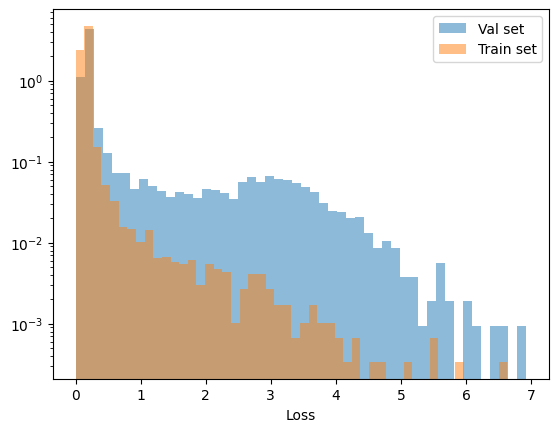

In [39]:
fig = plt.Figure(figsize=(16, 6))


plt.hist(val_losses, density=True, alpha=0.5, bins=50, label="Val set")
plt.hist(original_losses, density=True, alpha=0.5, bins=50, label="Train set")

plt.xlabel("Loss")
plt.yscale("log")
# plt.xlim((0, np.max(val_losses)))
plt.legend()

plt.show()